# Data Collection and Preprocessing
This notebook combines **data scraping** and **data preprocessing** steps.  

In [12]:
import sys
from pathlib import Path
import importlib.util
import matplotlib.pyplot as plt
import seaborn as sns

## Locate Project Root and `src` Directory
cwd = Path.cwd()
if cwd.name == "notebooks":
    project_root = cwd.parent
else:
    project_root = next((p for p in cwd.parents if (p / "src").exists()), cwd)
SRC_DIR = project_root / "src"
print(f"Project root: {project_root}")
print(f"Adding src to sys.path: {SRC_DIR}")
sys.path.insert(0, str(SRC_DIR))

# Validate `preprocessor.py` and Import It

preprocess_file = SRC_DIR / "preprocessor.py"
if not preprocess_file.exists():
    raise FileNotFoundError(f"Expected file not found: {preprocess_file}")
module_name = "preprocess"
try:
    preprocess_mod = importlib.import_module(module_name)
    print(f"Imported module '{module_name}' normally.")
except Exception as e:
    print(f"Normal import failed ({e}). Loading from file.")
    spec = importlib.util.spec_from_file_location(module_name, str(preprocess_file))
    preprocess_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(preprocess_mod)
    sys.modules[module_name] = preprocess_mod
    print(f"Loaded module '{module_name}' from {preprocess_file}")

## call `ReviewPreprocessor` Class

if hasattr(preprocess_mod, "ReviewPreprocessor"):
    ReviewPreprocessor = preprocess_mod.ReviewPreprocessor
    print("ReviewPreprocessor is ready to use.")
else:
    raise ImportError("'ReviewPreprocessor' not found in preprocess.py. Check class name inside the file.")

# Import Scraper and call `run_scraper`
scrap_file = SRC_DIR / "scraper.py"
run_scraper = None

if scrap_file.exists():
    try:
        scrap_mod = importlib.import_module("scraper")
    except Exception:
        spec = importlib.util.spec_from_file_location("scraper", str(scrap_file))
        scrap_mod = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(scrap_mod)
        sys.modules["scraper"] = scrap_mod

    if hasattr(scrap_mod, "run_scraper") and callable(scrap_mod.run_scraper):
        run_scraper = scrap_mod.run_scraper
    elif hasattr(scrap_mod, "main") and callable(scrap_mod.main):
        run_scraper = scrap_mod.main
    else:
        print("No callable 'run_scraper' or 'main' found in scrap.py. Define one to run the scraper.")
else:
    print(f"Warning: expected scraper file not found: {scrap_file}")

# Run Scraper (If Avail
if run_scraper:
    raw_df = run_scraper()
    display(raw_df.head())
else:
    print("run_scraper is not available. Check src/scrap.py for a callable 'main' or 'run_scraper'.")

## Run Preprocessor
preprocessor = ReviewPreprocessor()
success = preprocessor.process()

if success:
    df = preprocessor.df
    print(f"Preprocessing finished. Rows: {len(df)}")
else:
    print("Preprocessing failed.")


Project root: c:\Users\Administrator\Desktop\fintech-mobile-banking-reviews
Adding src to sys.path: c:\Users\Administrator\Desktop\fintech-mobile-banking-reviews\src
Imported module 'preprocess' normally.
ReviewPreprocessor is ready to use.
Starting Google Play Store Review Scraper

[1/2] Fetching app information...

CBE: Commercial Bank of Ethiopia
App ID: com.combanketh.mobilebanking
Current Rating: 4.3177056
Total Ratings: 38871
Total Reviews: 8337

Awash: Awash Bank
App ID: com.sc.awashpay
Current Rating: 4.321807
Total Ratings: 17791
Total Reviews: 3274

Amharabank: Amharabank
App ID: com.amharabank.Aba_mobile_banking
Current Rating: 4.451923
Total Ratings: 750
Total Reviews: 185

App information saved to C:\Users\Administrator\Desktop\fintech-mobile-banking-reviews\data\raw/app_info.csv

[2/2] Scraping reviews...


Banks:   0%|          | 0/3 [00:00<?, ?it/s]


Scraping reviews for com.combanketh.mobilebanking...
Successfully scraped 400 reviews
Collected 400 reviews for Commercial Bank of Ethiopia


Banks:  33%|███▎      | 1/3 [00:04<00:08,  4.02s/it]


Scraping reviews for com.sc.awashpay...
Successfully scraped 400 reviews
Collected 400 reviews for Awash Bank


Banks:  67%|██████▋   | 2/3 [00:07<00:03,  3.99s/it]


Scraping reviews for com.amharabank.Aba_mobile_banking...
Successfully scraped 183 reviews
Collected 183 reviews for Amharabank


Banks: 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


Scraping Complete!

Total reviews collected: 983
Reviews per bank:
  Commercial Bank of Ethiopia: 400
  Awash Bank: 400
  Amharabank: 183

Data saved to: C:\Users\Administrator\Desktop\fintech-mobile-banking-reviews\data\raw\reviews_raw.csv

Sample Reviews

Commercial Bank of Ethiopia:
------------------------------------------------------------

Rating: ⭐⭐⭐⭐⭐
Review: good...
Date: 2025-11-30 16:24:48

Rating: ⭐⭐⭐⭐⭐
Review: CBE ይለያል።...
Date: 2025-11-29 17:22:32

Rating: ⭐⭐⭐⭐⭐
Review: it's special for me...
Date: 2025-11-29 15:54:14

Awash Bank:
------------------------------------------------------------

Rating: ⭐⭐⭐
Review: I can't access the loan in the app. only it work in USSD...
Date: 2025-11-28 23:27:08

Rating: ⭐⭐⭐⭐⭐
Review: no one from all ethiopian bank keep it up nice...
Date: 2025-11-28 16:59:30

Rating: ⭐⭐⭐⭐⭐
Review: thenk you ✍️🙏...
Date: 2025-11-26 15:21:28

Amharabank:
------------------------------------------------------------

Rating: ⭐⭐⭐⭐⭐
Review: good...
Date: 202

,review_id,review_text,rating,review_date,user_name,thumbs_up,reply_content,bank_code,bank_name,app_id,source
0,361ac925-5bd6-4455-8efe-95394a4ba679,good,5,2025-11-30 16:24:48,Mahamed Abdireshid,0,None,CBE,Commercial Bank of Ethiopia,None,Google Play
1,cb37b096-e071-4f0f-a8fd-067b7d71706d,CBE ይለያል።,5,2025-11-29 17:22:32,Kamil Tesfaye,0,None,CBE,Commercial Bank of Ethiopia,5.2.1,Google Play
2,70f504ff-daed-40d9-9c89-cc49a95ef659,it's special for me,5,2025-11-29 15:54:14,Abde Semed,0,None,CBE,Commercial Bank of Ethiopia,5.2.1,Google Play
3,28f229b5-0026-41b9-a1eb-b76e74736f63,Make it user friendly.,2,2025-11-29 08:17:45,TOMIZ Creativity,0,None,CBE,Commercial Bank of Ethiopia,None,Google Play
4,68d8daea-db47-4e23-a692-755173dea983,maaliif daddafee install gaafata,3,2025-11-28 13:36:32,Tesfaye Abdi,0,None,CBE,Commercial Bank of Ethiopia,5.2.1,Google Play


STARTING DATA PREPROCESSING
Loading raw data...
Loaded 983 reviews

[1/6] Checking for missing data...

Missing values:
  reply_content: 980 (99.69%)
  app_id: 215 (21.87%)

[2/6] Handling missing values...

[3/6] Normalizing dates...
Date range: 2023-06-18 to 2025-11-30

[4/6] Cleaning text...

[5/6] Validating ratings...
All ratings are valid (1-5)

[6/6] Preparing final output...
Final dataset: 983 reviews

Saving processed data...
Data saved to: C:\Users\Administrator\Desktop\fintech-mobile-banking-reviews\data\processed\reviews_processed.csv

PREPROCESSING REPORT

Original records: 983
Records with missing critical data: 0
Empty reviews removed: 0
Invalid ratings removed: 0
Final records: 983

Data retention rate: 100.00%
Data error rate: 0.00%
✓ Data quality: EXCELLENT (<5% errors)

Reviews per bank:
  Awash Bank: 400
  Commercial Bank of Ethiopia: 400
  Amharabank: 183

Rating distribution:
  ⭐⭐⭐⭐⭐: 699 (71.1%)
  ⭐⭐⭐⭐: 94 (9.6%)
  ⭐⭐⭐: 41 (4.2%)
  ⭐⭐: 29 (3.0%)
  ⭐: 120 (12.2%)


# Basic Visualizations 
   Explore the cleaned dataset using plots:
- **Distribution of review lengths**
- **Rating distribution** 
- **Correlation heatmap** for numeric columns


Column 'rating' not found. Skipping rating distribution visualization.


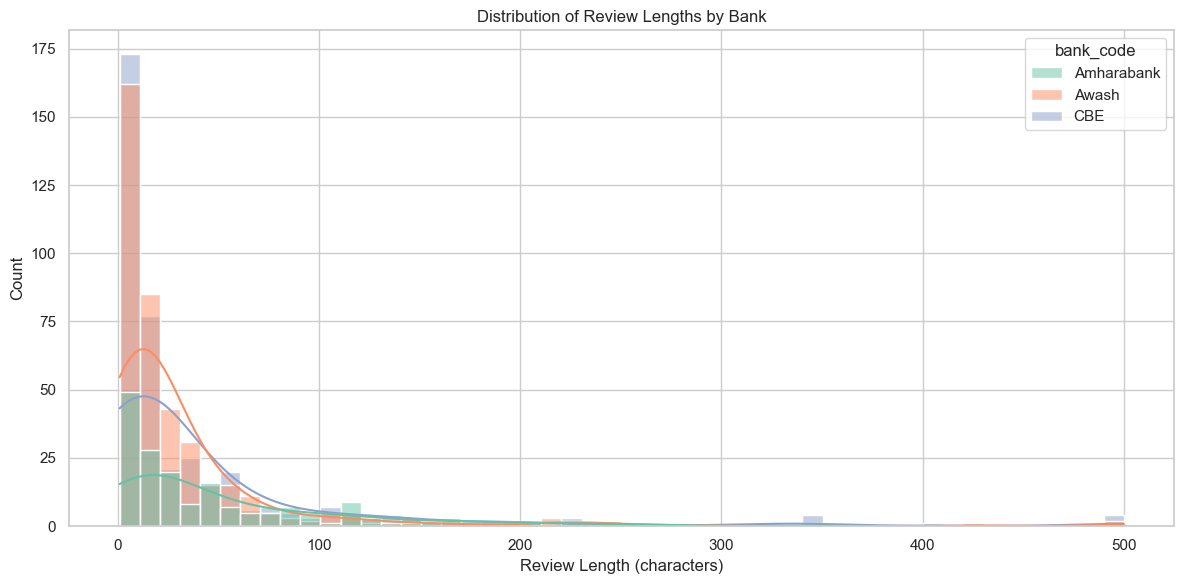

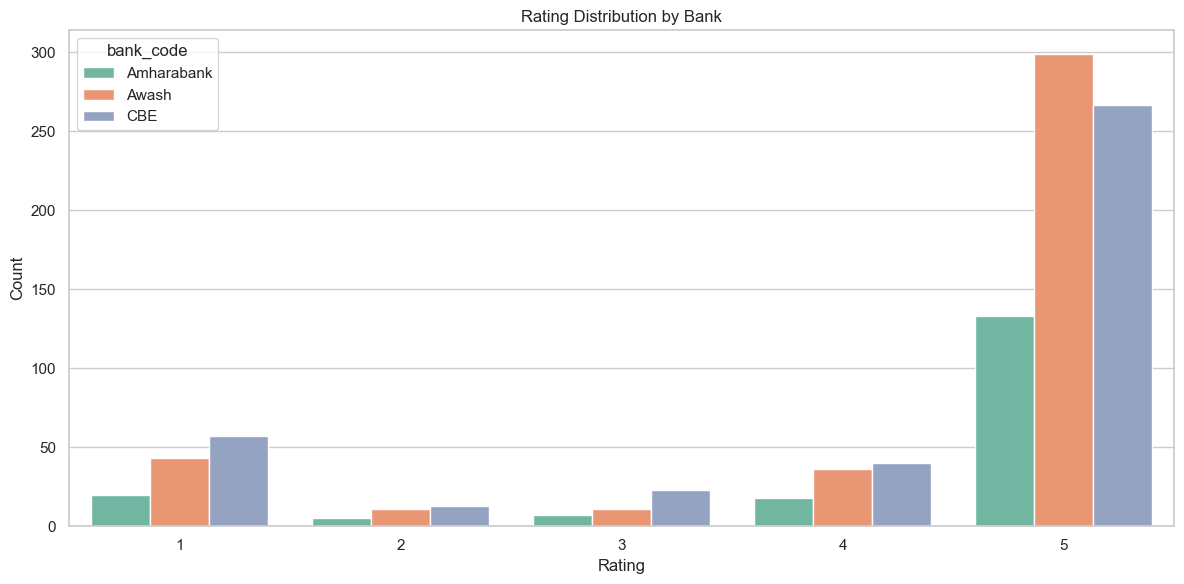

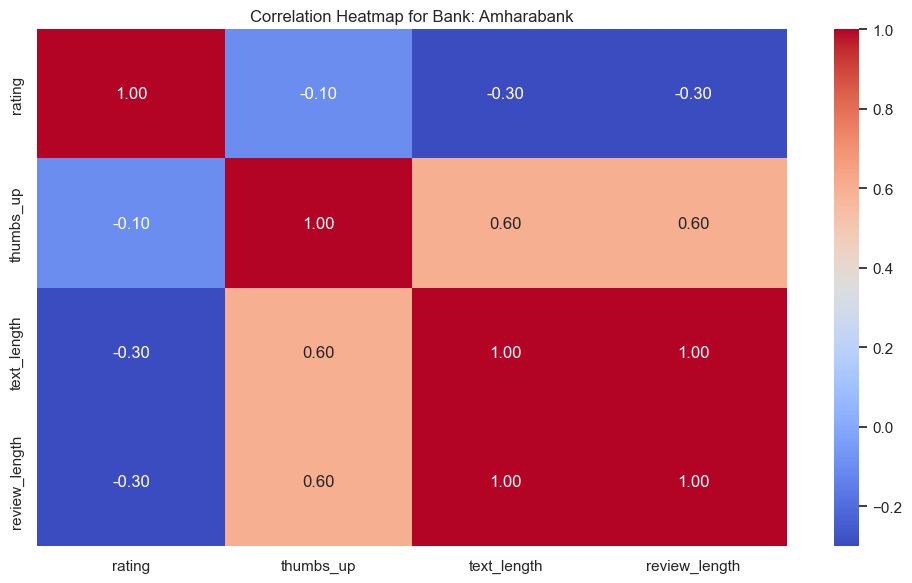

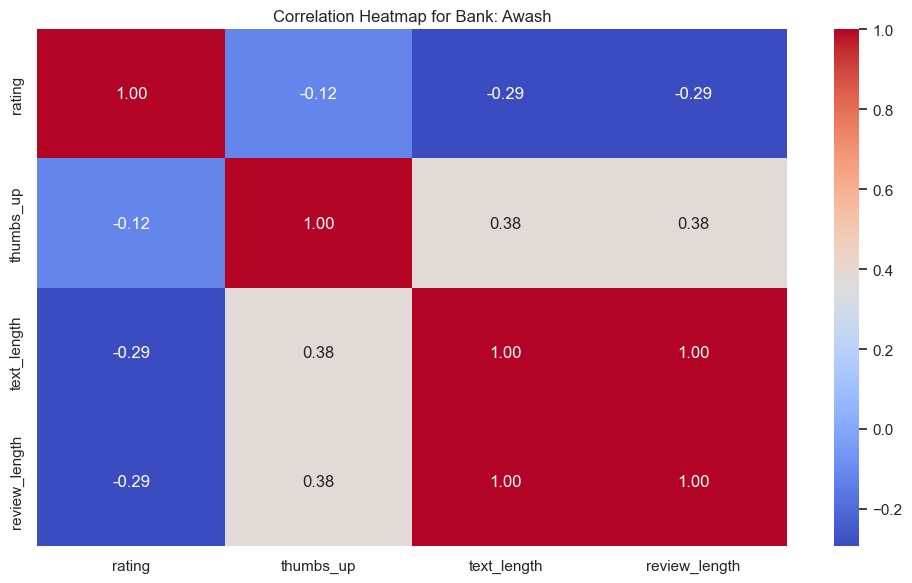

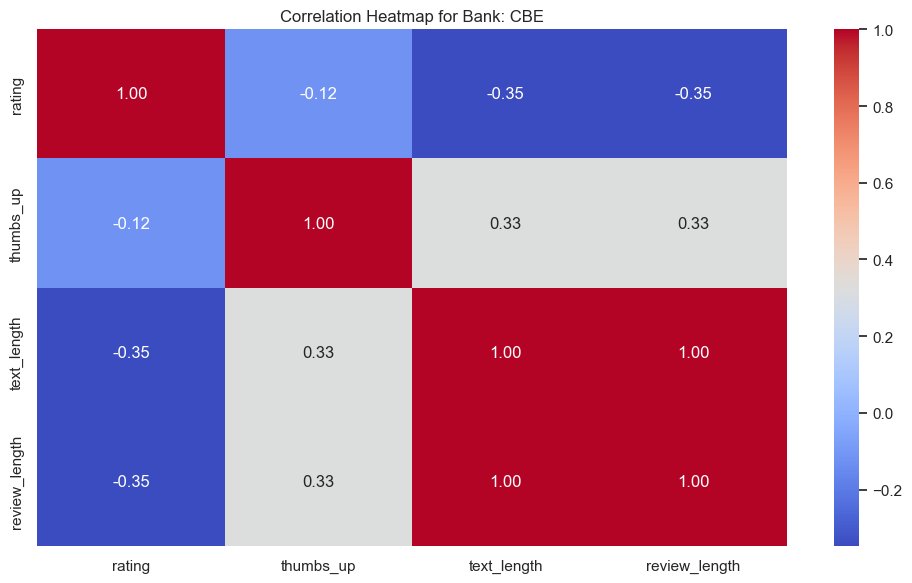

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# 1) Review Length Distribution by Bank
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', bins=50, kde=True, hue='bank_code', palette='Set2')
plt.title('Distribution of Review Lengths by Bank')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2) Rating Distribution by Bank
if 'rating' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='rating', hue='bank_code', palette='Set2')
    plt.title('Rating Distribution by Bank')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'rating' not found. Skipping rating distribution visualization.")

# Correlation Heatmap grouped by Bank
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

if len(numeric_cols) > 1 and 'bank_code' in df.columns:
    unique_banks = df['bank_code'].unique()
    for bank in unique_banks:
        subset = df[df['bank_code'] == bank]
        corr = subset[numeric_cols].corr()

        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f'Correlation Heatmap for Bank: {bank}')
        plt.tight_layout()
        plt.show()
else:
    print("Not enough numeric columns or 'bank_code' missing for correlation heatmap.")

